In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx
import numpy as np
import pandas as pd
from networkx.readwrite import json_graph
import json
from matplotlib import pyplot
import scipy.stats
from sklearn.linear_model import LinearRegression
from bs4 import BeautifulSoup
import re
import csv
import requests
import math
from scipy.stats import norm, kurtosis, skew
from sklearn.cluster import KMeans
from scipy.optimize import least_squares
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline

In [2]:
df_filmes = pd.read_csv('df_brnovfinal.csv')

In [3]:
df_filmes.head()

,Unnamed: 0,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,isAdult,new_title,originalTitle,primaryTitle,runtimeMinutes,startYear,tconst,titleType,total,year
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,limite,Limite,Limite,114,1931,tt0022080,movie,2.0,1931.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,ganga bruta,Ganga Bruta,Ganga Bruta,82,1933,tt0024049,movie,1.0,1933.0
2,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,a voz do carnaval,A Voz do Carnaval,A Voz do Carnaval,\N,1933,tt0024743,movie,2.0,1933.0
3,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,alo alo brasil,"Alô, Alô, Brasil","Alô, Alô, Brasil",78,1935,tt0026063,movie,2.0,1935.0
4,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,estudantes,Estudantes,Estudantes,70,1935,tt0026323,movie,2.0,1935.0


In [4]:
df_filmes.shape

(5366, 44)

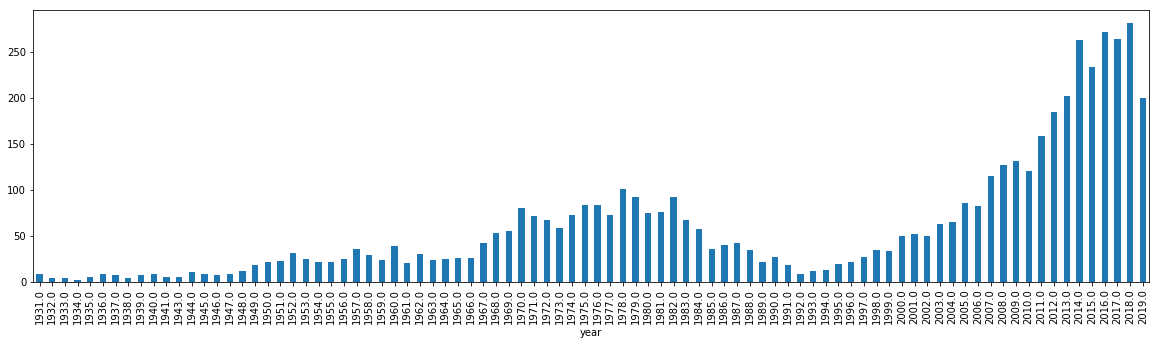

In [4]:
df_filmes[df_filmes.year!=0].groupby('year').count().total.plot.bar(figsize=(20,5))

In [5]:
df_dist = pd.DataFrame()
for tconst in ['tt0271383']:
    url = 'https://www.imdb.com/title/'+tconst+'/ratings?ref_=tt_ov_rt'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    dist = []
    for i in soup.find_all('div', class_='leftAligned')[1:]:
        try:
            dist.append(int((re.search(r'\d+', str(i).replace(',', ''))[0])))
        except:
            pass
    if (len(dist)==10):
        df_dist[tconst] = dist

## DataFrame

In [6]:
df = pd.read_csv('df_dist_drive1601.csv').iloc[:,1:].T
df.columns = np.arange(10,0,-1).astype(str)
df['total'] = df.sum(axis=1)
df['tconst'] = df.index
df['title'] = [df_filmes[df_filmes.tconst==tconst].originalTitle.values[0] for tconst in df.tconst]
df['year'] = [df_filmes[df_filmes.tconst==tconst].year.values[0] for tconst in df.tconst]

In [7]:
df.head()

,10,9,8,7,6,5,4,3,2,1,total,tconst,title,year
tt0022080,354,230,298,276,168,101,55,41,40,68,1631,tt0022080,Limite,1931.0
tt0024049,39,30,50,78,54,20,15,6,2,3,297,tt0024049,Ganga Bruta,1933.0
tt0024743,2,0,1,1,1,2,0,0,0,0,7,tt0024743,A Voz do Carnaval,1933.0
tt0026063,1,1,1,1,1,0,0,0,1,0,6,tt0026063,"Alô, Alô, Brasil",1935.0
tt0027278,3,1,2,5,11,2,2,0,0,0,26,tt0027278,Alô Alô Carnaval,1936.0


In [8]:
def get_distribution(notas):
    dist = []
    base = np.arange(10,0,-1)
    for i in range(len(notas)):
        sup = np.array(np.repeat([base[i]], notas[i]).tolist())
        for j in sup:
            dist.append(j)
    return np.array(dist)

def mean_(tconst):
    return get_distribution(df.loc[tconst]['10':'1'].values).mean()

def var_(tconst):
    return get_distribution(df.loc[tconst]['10':'1'].values).var()

def kurt_(tconst):
    return kurtosis(get_distribution(df.loc[tconst]['10':'1'].values), fisher=False, bias=True, nan_policy='propagate')

def skew_(tconst):
    return skew(get_distribution(df.loc[tconst]['10':'1'].values), bias=True, nan_policy='propagate')

In [9]:
def morales(tconst):
    array = df.loc[tconst, '10':'1'].values
    delt_A = np.abs(array[:5].sum()-array[5:].sum())/array.sum()
    
    dist = get_distribution(df.loc[tconst]['10':'1'].values)
    if (len(dist[dist>5])==0):
        d = np.abs(-dist[dist<=5].mean())/9
    elif (len(dist[dist<=5])==0):
        d = np.abs(dist[dist>5].mean())/9
    else:
        d = np.abs(dist[dist>5].mean()-dist[dist<=5].mean())/9
    
    return (1-delt_A)*d

In [10]:
def gini2(tconst):
    arr = get_distribution(df.loc[tconst]['10':'1'].values)
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

In [11]:
#Fisher = False
def dist_cent(title):
    return (math.sqrt((df[df.index==title]['kurt_'])**2+(df[df.index==title]['var_']-81/4)**2))

In [12]:
#Fisher = False
def dist_uni(title):
    return (math.sqrt((df[df.index==title]['kurt_'])**2+(df[df.index==title]['var_'])**2))

In [13]:
df['morales'] = df.tconst.apply(morales)
df['kurt_'] = df.tconst.apply(kurt_)
df['skew_'] = df.tconst.apply(skew_)
df['var_'] = df.tconst.apply(var_)
df['meu'] = df.tconst.apply(dist_cent)

In [254]:
df['meu2'] = df.tconst.apply(dist_uni)

In [240]:
df['gini'] = df.tconst.apply(gini2)

In [242]:
array = np.array([150, 0, 0, 0, 0, 0, 0, 0, 0, 0])
delt_A = np.abs(array[:5].sum()-array[5:].sum())/array.sum()
    
dist = get_distribution(df.loc[tconst]['10':'1'].values)
if (len(dist[dist>5])==0):
    d = np.abs(-dist[dist<=5].mean())/9
elif (len(dist[dist<=5])==0):
    d = np.abs(dist[dist>5].mean())/9
else:
    d = np.abs(dist[dist>5].mean()-dist[dist<=5].mean())/9
(1-delt_A)*d

0.0

In [250]:
dist.var()

0.0

In [251]:
dist = get_distribution(array)
kurto = kurtosis(dist, fisher=False, bias=True, nan_policy='propagate')
vari = dist.var()
math.sqrt((kurto)**2+(vari-81/4)**2)

20.25

In [216]:
df[df.total>100].sort_values(by='morales', ascending=False)

,10,9,8,7,6,5,4,3,2,1,total,tconst,morales,kurt_,skew_,var_,meu,gini
tt8528864,157,12,7,3,3,2,1,8,18,144,355,tt8528864,0.918513,1.060053,-0.043131,18.486126,2.057903,0.398381
tt10738914,210,2,2,6,11,12,10,22,30,177,482,tt10738914,0.862661,1.118929,0.051001,17.469762,2.996953,0.403374
tt5431016,339,25,19,10,25,26,22,24,32,523,1045,tt5431016,0.723516,1.270600,0.389143,16.995494,3.493742,0.460507
tt4930760,189,4,19,22,32,38,50,50,35,142,581,tt4930760,0.684252,1.388222,0.110719,13.408942,6.980489,0.374257
tt6791886,385,55,79,135,129,89,48,28,41,380,1369,tt6791886,0.621429,1.474678,-0.179513,12.938659,7.458578,0.350127
tt6051554,398,58,59,60,27,22,11,11,18,259,923,tt6051554,0.597228,1.510283,-0.541081,14.997989,5.464849,0.313245
tt5968964,61,11,14,23,34,27,23,14,11,120,338,tt5968964,0.581591,1.607490,0.298219,11.909501,8.493995,0.408290
tt5797820,165,36,63,103,89,56,20,17,29,211,789,tt5797820,0.576277,1.572116,-0.173493,11.681119,8.711904,0.344281
tt4096762,22,3,10,11,17,14,10,8,6,23,124,tt4096762,0.575155,1.807693,0.004502,9.585523,10.816599,0.324743
tt5812510,22,3,7,4,9,11,12,6,6,22,102,tt5812510,0.572182,1.641134,0.148871,10.972318,9.421714,0.355592


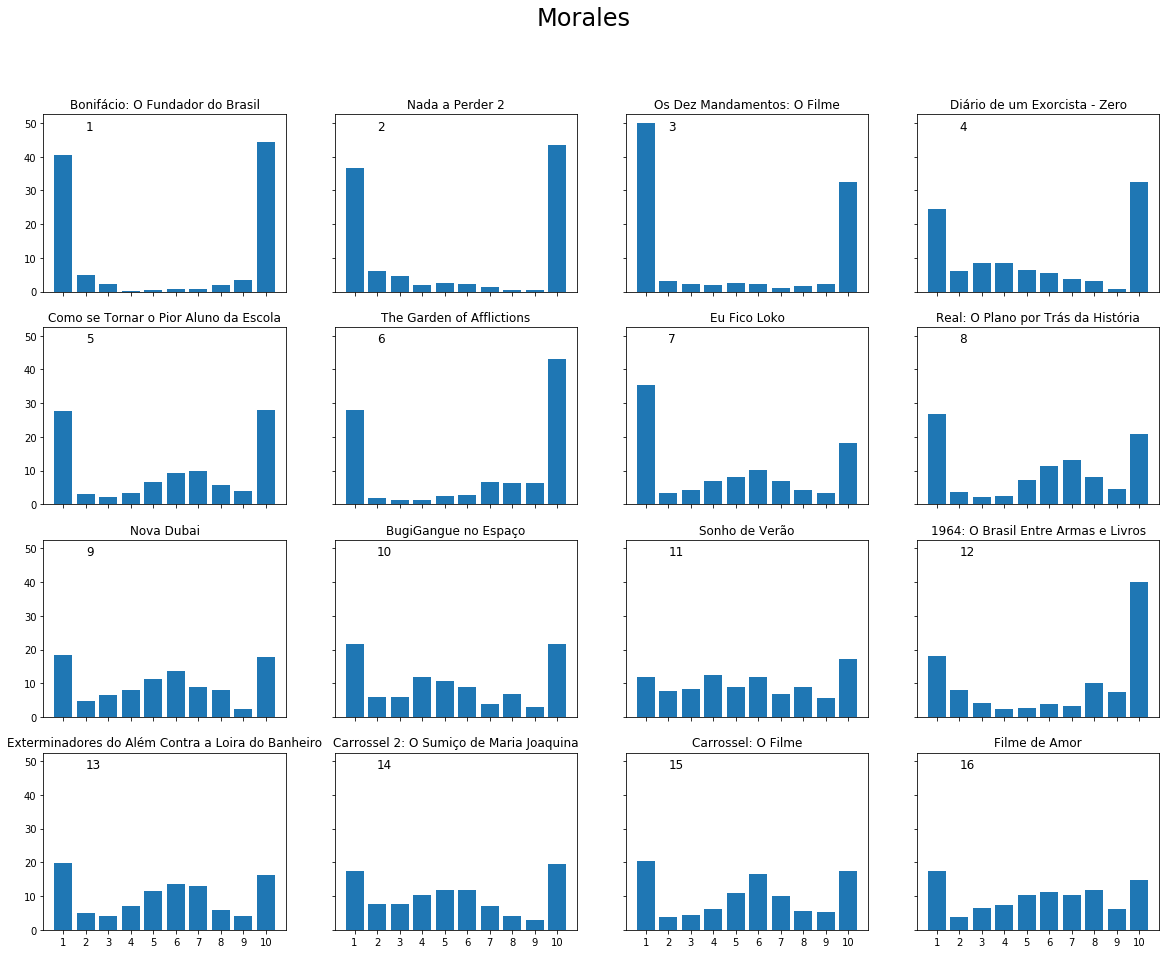

In [157]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize=(20, 15), sharey=True, sharex=True)
i=0
for ax in axs.flatten():
    ax.bar(np.arange(1, 11).astype(str),np.flip(df[df.total>100].sort_values(by='morales', ascending=False).iloc[i,0:10].values*100/df[df.total>100].sort_values(by='morales', ascending=False).iloc[i,0:10].values.sum()))
    ax.text('2', 48, s=str(i+1), fontsize=12)
    ax.set_title(df[df.total>100].sort_values(by='morales', ascending=False).title.values[i])
    i+=1
plt.suptitle('Morales', fontsize=24)
plt.savefig('morales.png', dpi=200, bbox_inches='tight')

In [173]:
df[df.tconst=='tt1319731']

,10,9,8,7,6,5,4,3,2,1,...,tconst,title,year,morales,kurt_,skew_,var_,meu,extremos,gini
tt1319731,25,30,82,46,19,2,2,0,0,0,...,tt1319731,Pro Dia Nascer Feliz,2005.0,0.015017,3.230422,-0.195999,1.458384,19.067261,0.121359,0.082518


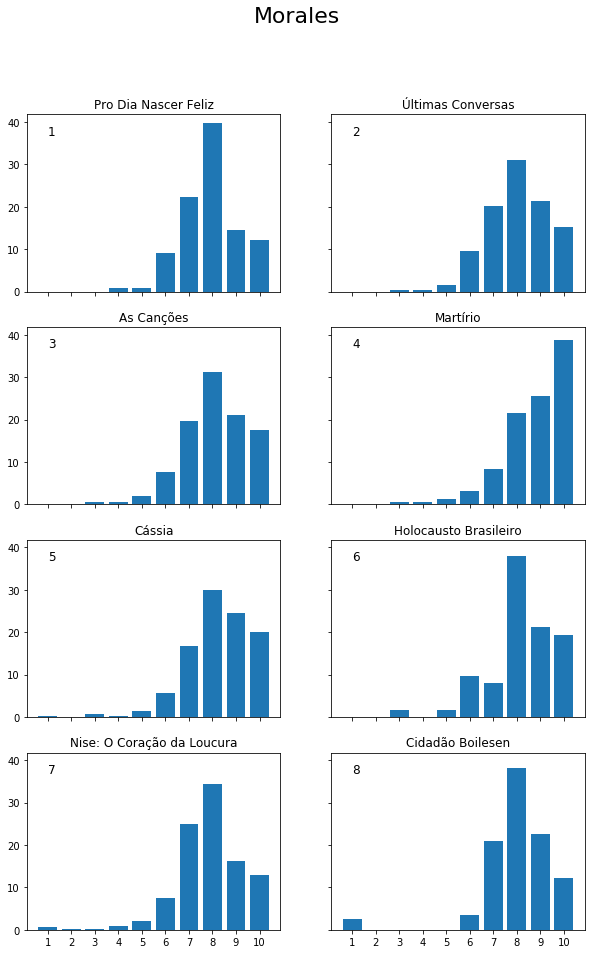

In [193]:
fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize=(10, 15), sharey=True, sharex=True)
i=0
for ax in axs.flatten():
    ax.bar(np.arange(1, 11).astype(str),np.flip(df[df.total>100].sort_values(by='morales', ascending=True).iloc[i,0:10].values*100/df[df.total>100].sort_values(by='morales', ascending=True).iloc[i,0:10].values.sum()))
    ax.text('1', 37, s=str(i+1), fontsize=12)
    ax.set_title(df[df.total>100].sort_values(by='morales', ascending=True).title.values[i])
    i+=1
plt.suptitle('Morales', fontsize=22)
plt.savefig('morales_ultimos.png', dpi=200, bbox_inches='tight')

In [76]:
df[df.total>100].sort_values(by='morales', ascending=False).iloc[:10,:]

,10,9,8,7,6,5,4,3,2,1,total,tconst,title,year,morales,kurt_,skew_,var_,meu
tt8528864,157,12,7,3,3,2,1,8,18,144,355,tt8528864,Bonifácio: O Fundador do Brasil,2018.0,0.918513,1.060053,-0.043131,18.486126,2.057903
tt10738914,210,2,2,6,11,12,10,22,30,177,482,tt10738914,Nada a Perder 2,2019.0,0.862661,1.118929,0.051001,17.469762,2.996953
tt5431016,339,25,19,10,25,26,22,24,32,523,1045,tt5431016,Os Dez Mandamentos: O Filme,2016.0,0.723516,1.270600,0.389143,16.995494,3.493742
tt4930760,189,4,19,22,32,38,50,50,35,142,581,tt4930760,Diário de um Exorcista - Zero,2016.0,0.684252,1.388222,0.110719,13.408942,6.980489
tt6791886,385,55,79,135,129,89,48,28,41,380,1369,tt6791886,Como se Tornar o Pior Aluno da Escola,2017.0,0.621429,1.474678,-0.179513,12.938659,7.458578
tt6051554,398,58,59,60,27,22,11,11,18,259,923,tt6051554,The Garden of Afflictions,2017.0,0.597228,1.510283,-0.541081,14.997989,5.464849
tt5968964,61,11,14,23,34,27,23,14,11,120,338,tt5968964,Eu Fico Loko,2017.0,0.581591,1.607490,0.298219,11.909501,8.493995
tt5797820,165,36,63,103,89,56,20,17,29,211,789,tt5797820,Real: O Plano por Trás da História,2017.0,0.576277,1.572116,-0.173493,11.681119,8.711904
tt4096762,22,3,10,11,17,14,10,8,6,23,124,tt4096762,Nova Dubai,2014.0,0.575155,1.807693,0.004502,9.585523,10.816599
tt5812510,22,3,7,4,9,11,12,6,6,22,102,tt5812510,BugiGangue no Espaço,2017.0,0.572182,1.641134,0.148871,10.972318,9.421714


In [252]:
df[df.total>100].sort_values(by='meu', ascending=False)

,10,9,8,7,6,5,4,3,2,1,total,tconst,title,year,morales,kurt_,skew_,var_,meu,gini
tt2495980,81,7,16,16,23,40,29,43,45,2269,2569,tt2495980,É Fada!,2016.0,0.093916,14.725113,3.543539,3.582112,22.240671,0.338294
tt6544940,223,205,118,12,8,9,4,1,4,7,591,tt6544940,Coração de Cowboy,2018.0,0.055844,13.149056,-2.791708,2.320808,22.234064,0.076216
tt1977750,14,26,44,24,4,0,0,0,0,3,115,tt1977750,Cidadão Boilesen,2009.0,0.041718,12.037884,-2.318984,2.339055,21.580376,0.089260
tt0317248,179804,215958,161600,61960,19164,8238,3935,2373,2177,9131,664340,tt0317248,Cidade de Deus,2002.0,0.049688,10.242092,-2.203306,2.432227,20.551727,0.088041
tt0271383,3501,2669,2234,876,268,136,53,44,35,145,9961,tt0271383,O Auto da Compadecida,2000.0,0.054038,9.786520,-2.191109,2.640941,20.145842,0.090479
tt3119922,15,24,46,16,9,2,0,0,0,3,115,tt3119922,Dossiê Jango,2013.0,0.053931,9.604860,-2.000447,2.613686,20.082154,0.098309
tt1039960,540,856,1795,1087,292,82,27,22,29,41,4771,tt1039960,Estômago,2007.0,0.043627,7.983339,-1.469425,2.086082,19.840907,0.092610
tt0333388,269,261,333,140,52,15,4,4,7,11,1096,tt0333388,Edifício Master,2002.0,0.044925,8.273856,-1.740108,2.427020,19.649817,0.094296
tt2428824,84,2,165,261,7,4,2,1,0,19,545,tt2428824,Anita e Garibaldi,2013.0,0.062279,9.016689,-1.668836,2.796485,19.644996,0.100488
tt1789810,866,547,446,208,68,31,9,8,14,40,2237,tt1789810,José e Pilar,0.0,0.062131,9.355199,-2.206479,2.994779,19.628102,0.095388


In [168]:
df[df.total>100].sort_values(by='morales', ascending=True).iloc[:15,:][['title', 'year']]

,title,year
tt1319731,Pro Dia Nascer Feliz,2005.0
tt4611160,Últimas Conversas,2015.0
tt2139601,As Canções,2011.0
tt6788828,Martírio,2016.0
tt3096778,Cássia,2014.0
tt6410688,Holocausto Brasileiro,2016.0
tt2168180,Nise: O Coração da Loucura,2015.0
tt1977750,Cidadão Boilesen,2009.0
tt1039960,Estômago,2007.0
tt1754803,Uma Noite em 67,2010.0


In [166]:
df[df.total>100].sort_values(by='morales', ascending=False).iloc[:15,:][['title', 'year']].to_excel('ranking_morales.xlsx')

'Inspetor Faustão e o Mallandro: A Missão (Primeira e Única)'

In [33]:
df[df.total>100].sort_values(by='meu', ascending=True)

,10,9,8,7,6,5,4,3,2,1,total,tconst,title,year,morales,kurt_,skew_,var_,meu
tt8528864,157,12,7,3,3,2,1,8,18,144,355,tt8528864,Bonifácio: O Fundador do Brasil,2018.0,0.918513,1.060053,-0.043131,18.486126,2.057903
tt10738914,210,2,2,6,11,12,10,22,30,177,482,tt10738914,Nada a Perder 2,2019.0,0.862661,1.118929,0.051001,17.469762,2.996953
tt5431016,339,25,19,10,25,26,22,24,32,523,1045,tt5431016,Os Dez Mandamentos: O Filme,2016.0,0.723516,1.270600,0.389143,16.995494,3.493742
tt6051554,398,58,59,60,27,22,11,11,18,259,923,tt6051554,The Garden of Afflictions,2017.0,0.597228,1.510283,-0.541081,14.997989,5.464849
tt6910020,16866,98,63,91,93,117,53,104,185,5092,22762,tt6910020,Nada a Perder,2018.0,0.475048,2.463640,-1.194562,14.405049,6.342947
tt0275425,49,2,8,4,4,6,15,7,22,97,214,tt0275425,Inspetor Faustão e o Mallandro: A Missão (Prim...,1991.0,0.528705,1.759077,0.711614,13.860424,6.627294
tt7825208,9439,130,68,36,14,24,23,75,415,32059,42283,tt7825208,Marighella,2019.0,0.454798,2.668622,1.287380,14.146625,6.661286
tt4930760,189,4,19,22,32,38,50,50,35,142,581,tt4930760,Diário de um Exorcista - Zero,2016.0,0.684252,1.388222,0.110719,13.408942,6.980489
tt10135068,171,32,43,14,16,12,10,18,34,77,427,tt10135068,1964: O Brasil Entre Armas e Livros,2019.0,0.566458,1.571018,-0.539630,13.392176,7.035471
tt9705194,29,4,1,1,0,1,4,11,23,59,133,tt9705194,Milagre,2019.0,0.474878,2.105560,0.964391,13.506021,7.065029


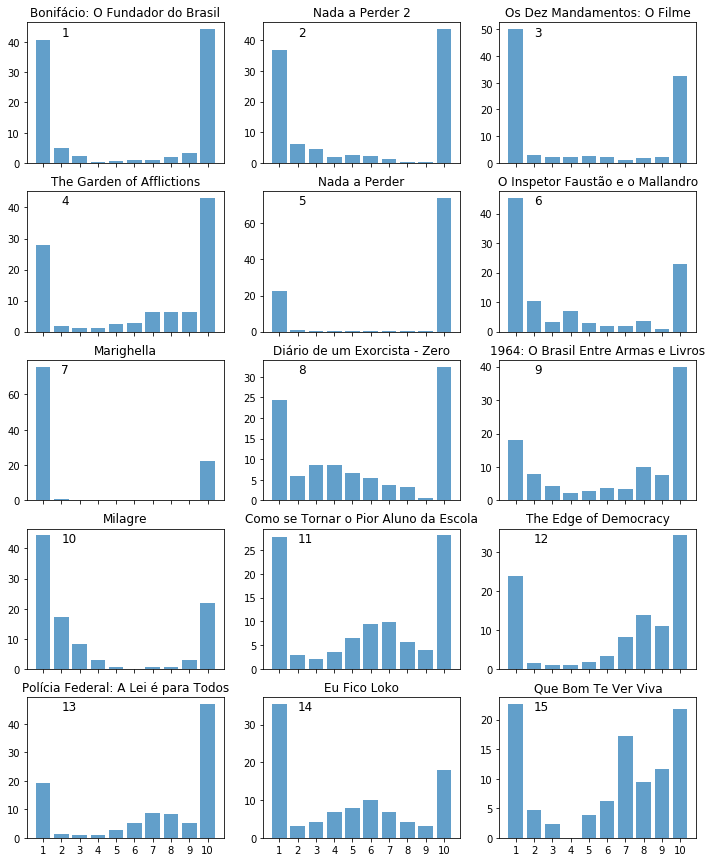

In [36]:
fig, axs = plt.subplots(nrows = 5, ncols = 3, figsize=(12, 15), sharey=False, sharex=True)
i=0
for ax in axs.flatten():
    ax.bar(np.arange(1, 11).astype(str),np.flip(df[df.total>100].sort_values(by='meu', ascending=True).iloc[i,0:10].values*100/df[df.total>100].sort_values(by='meu', ascending=True).iloc[i,0:10].values.sum()), alpha=.7)
    #ax.text('2', 48, s=str(i+1), fontsize=12)
    if (df[df.total>100].sort_values(by='meu', ascending=True).title.values[i]==df[df.index=='tt0275425'].title.values[0]):
        ax.set_title('O Inspetor Faustão e o Mallandro')
    else:
        ax.set_title(df[df.total>100].sort_values(by='meu', ascending=True).title.values[i])
    maxi = np.flip(df[df.total>100].sort_values(by='meu', ascending=True).iloc[i,0:10].values*100/df[df.total>100].sort_values(by='meu', ascending=True).iloc[i,0:10].values.sum()).max()
    maxi = maxi-.05*maxi
    ax.text('2', maxi, s=str(i+1), fontsize=12)
    i+=1
plt.savefig('meu.png', dpi=200, bbox_inches='tight')

In [38]:
df.sort_values(by='total', ascending=False)

,10,9,8,7,6,5,4,3,2,1,total,tconst,title,year,morales,kurt_,skew_,var_,meu
tt0317248,179804,215958,161600,61960,19164,8238,3935,2373,2177,9131,664340,tt0317248,Cidade de Deus,2002.0,0.049688,10.242092,-2.203306,2.432227,20.551727
tt0861739,18598,21122,31001,14702,4569,1666,683,390,267,1110,94108,tt0861739,Tropa de Elite,2007.0,0.048712,7.962195,-1.627339,2.397643,19.547460
tt1555149,14722,17293,24120,12651,3952,1418,578,351,285,1036,76406,tt1555149,Tropa de Elite 2: O Inimigo Agora é Outro,2010.0,0.054107,7.785671,-1.643652,2.557555,19.329751
tt0861689,4372,5172,12277,17859,12650,6161,3163,1788,1288,2489,67219,tt0861689,Ensaio Sobre a Cegueira,0.0,0.188127,3.759632,-0.792708,4.127391,16.555161
tt7825208,9439,130,68,36,14,24,23,75,415,32059,42283,tt7825208,Marighella,2019.0,0.454798,2.668622,1.287380,14.146625,6.661286
tt0337692,2612,1791,4572,8596,9316,5586,2620,1283,827,1301,38504,tt0337692,Na Estrada - On The Road,0.0,0.225019,3.383455,-0.403854,4.052230,16.547372
tt0140888,9378,6143,9222,5024,1824,714,288,190,183,755,33721,tt0140888,Central do Brasil,1998.0,0.077242,6.975639,-1.687144,3.392901,18.243391
tt6910020,16866,98,63,91,93,117,53,104,185,5092,22762,tt6910020,Nada a Perder,2018.0,0.475048,2.463640,-1.194562,14.405049,6.342947
tt1702014,5376,4144,5390,3636,1484,413,178,96,64,273,21054,tt1702014,Hoje Eu Quero Voltar Sozinho,2014.0,0.054357,6.474492,-1.413891,2.814763,18.598563
tt1921149,1779,2042,5138,6085,2614,889,336,143,89,185,19300,tt1921149,Trash - A Esperança vem do Lixo,0.0,0.069358,5.305469,-0.841618,2.441548,18.581953


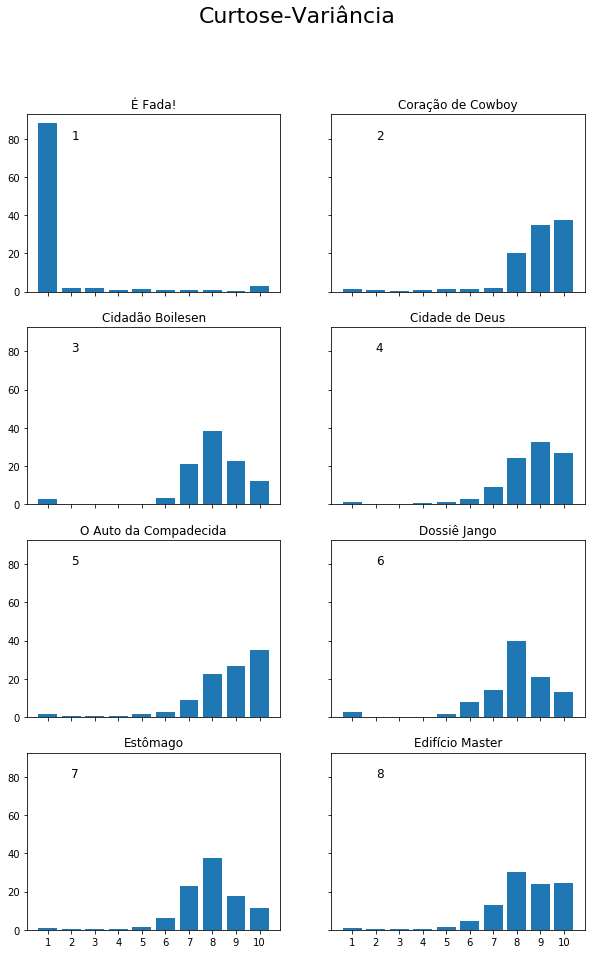

In [183]:
fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize=(10, 15), sharey=True, sharex=True)
i=0
for ax in axs.flatten():
    ax.bar(np.arange(1, 11).astype(str),np.flip(df[df.total>100].sort_values(by='meu', ascending=False).iloc[i,0:10].values*100/df[df.total>100].sort_values(by='meu', ascending=False).iloc[i,0:10].values.sum()))
    #ax.text('2', 48, s=str(i+1), fontsize=12)
    ax.set_title(df[df.total>100].sort_values(by='meu', ascending=False).title.values[i])
    maxi = np.flip(df[df.total>100].sort_values(by='meu', ascending=False).iloc[i,0:10].values*100/df[df.total>100].sort_values(by='meu', ascending=True).iloc[i,0:10].values.sum()).max()
    maxi = maxi-.05*maxi
    ax.text('2', 80, s=str(i+1), fontsize=12)
    i+=1
plt.suptitle('Curtose-Variância', fontsize=22)
plt.savefig('meu_ultimos.png', dpi=200, bbox_inches='tight')

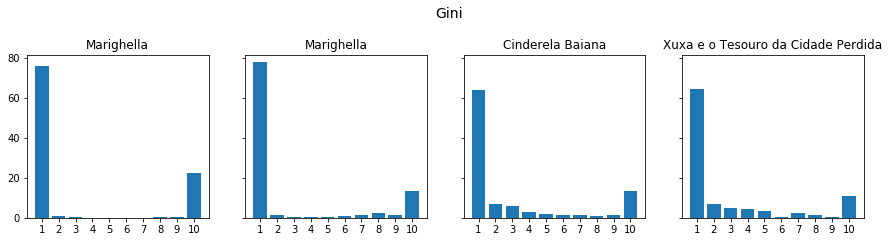

In [151]:
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(15, 3), sharey=True, sharex=True)
i=0
for ax in axs.flatten():
    ax.bar(np.arange(1, 11).astype(str),np.flip(df[df.total>100].sort_values(by='gini', ascending=False).iloc[i,0:10].values*100/df[df.total>100].sort_values(by='gini', ascending=False).iloc[i,0:10].values.sum()))
    ax.set_title(df[df.total>100].sort_values(by='gini', ascending=False).title.values[i])
    i+=1
    
plt.text(-15.5, 100, 'Gini', fontsize=14)
plt.savefig('gini.png', dpi=200, bbox_inches='tight')

In [86]:
df.loc[tconst,'1']

380

In [89]:
df['extremos'] = [(df.loc[tconst,'1']+df.loc[tconst, '10'])/df.loc[tconst].total for tconst in df.tconst]

In [91]:
df.head()

,10,9,8,7,6,5,4,3,2,1,total,tconst,title,year,morales,kurt_,skew_,var_,meu,extremos
tt0022080,354,230,298,276,168,101,55,41,40,68,1631,tt0022080,Limite,1931.0,0.206960,3.397639,-0.973236,5.771702,14.871620,0.258737
tt0024049,39,30,50,78,54,20,15,6,2,3,297,tt0024049,Ganga Bruta,1933.0,0.126229,3.383813,-0.481504,3.500459,17.087929,0.141414
tt0024743,2,0,1,1,1,2,0,0,0,0,7,tt0024743,A Voz do Carnaval,1933.0,0.203175,1.545898,0.263867,3.918367,16.404634,0.285714
tt0026063,1,1,1,1,1,0,0,0,1,0,6,tt0026063,"Alô, Alô, Brasil",1935.0,0.222222,2.715000,-0.871421,6.666667,13.852010,0.166667
tt0027278,3,1,2,5,11,2,2,0,0,0,26,tt0027278,Alô Alô Carnaval,1936.0,0.088578,2.948994,0.671554,2.597633,17.897000,0.115385


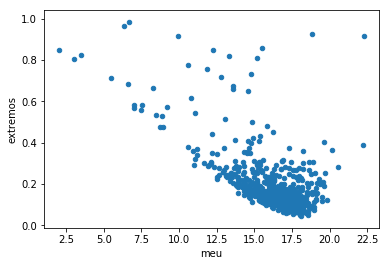

In [97]:
df[df.total>200].plot.scatter('meu', 'extremos')

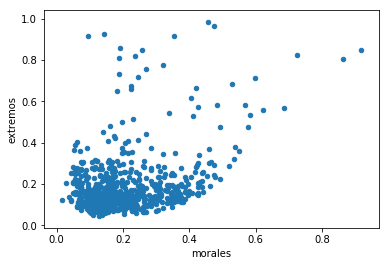

In [98]:
df[df.total>200].plot.scatter('morales', 'extremos')

AttributeError: 'numpy.ndarray' object has no attribute 'bar'

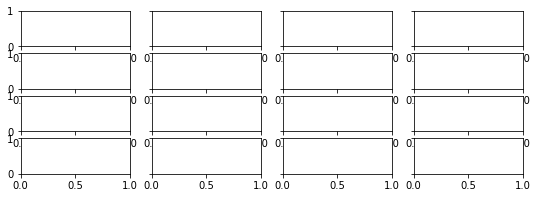

In [21]:

i=0
for title in df[df.total>100].sort_values(by='morales', ascending=False).tconst[:16]:
    ax = axs[i]
    ax.bar(np.arange(10,0, -1), df.loc[title, '10':'1'].values*100/df.loc[title, '10':'1'].values.sum())
    ax.title(df[df.tconst==title].title.values[0])
    plt.show()
    i+1

In [18]:
len(axs)

10

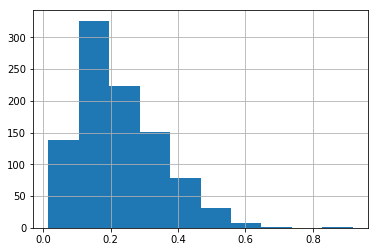

In [181]:
df[df.total>100]['morales'].hist()

In [60]:
morales('tt0022080')

0.20696027209533893

In [30]:
df['mean_'] = [mean_(t) for t in df.index]
df['var_'] = [var_(t) for t in df.index]
df['kurt_'] = [kurt_(t) for t in df.index]
df['skew_'] = [skew_(t) for t in df.index]

### Gini

In [196]:
df_gini = df[df.total>100]

In [198]:
def gini_dist(dist):
    array = dist
    b = 0
    for i in range(len(array)):
        for j in range(len(array)):
            b+=np.abs(j-i)*array[i]*array[j]
    return b/(2*(array.sum()**2)*np.mean(get_distribution(array)))

In [218]:
def T(tconst):
    a = get_distribution(df_gini.loc[tconst]['10':'1'].values)
    median = np.median(a)
    #median=4.5
    mu_u = np.mean(a[a<median])
    if (len(a[a<median])==0):
        mu_u=median
    
    mu_l = np.mean(a[a>median])
    if (len(a[a>median])==0):
        mu_l=median
    return (mu_u-mu_l)/np.mean(a)

In [ ]:
def index2(tconst):
    array = get_distribution(df.loc[tconst]['10':'1'].values)
    return (T(tconst)-gini2(tconst))*(np.mean(array)/np.median(array))

In [118]:
df_gini['T'] = df_gini.tconst.apply(T)
df_gini['gini'] = df_gini.tconst.apply(gini2)
df_gini['index2'] = df_gini.tconst.apply(index2)


NameError: name 'df_gini' is not defined

In [235]:
df_gini.sort_values(by='index2', ascending=True)

,10,9,8,7,6,5,4,3,2,1,...,tconst,title,year,mean_,var_,kurt_,skew_,T,gini,index2
tt7825208,9439,130,68,36,14,24,23,75,415,32059,...,tt7825208,Marighella,2019.0,3.068988,14.146625,2.668622,1.287380,-2.788096,0.519111,-10.149775
tt5431016,339,25,19,10,25,26,22,24,32,523,...,tt5431016,Os Dez Mandamentos: O Filme,2016.0,4.654545,16.995494,1.270600,0.389143,-1.571817,0.460507,-9.459541
tt2357958,400,36,64,45,25,11,15,16,42,2283,...,tt2357958,Marighella,2012.0,2.666326,11.013619,3.659447,1.591228,-2.806551,0.506817,-8.834521
tt1442576,150,50,87,167,181,144,82,42,58,1147,...,tt1442576,"Lula, o Filho do Brasil",2009.0,3.481025,9.697458,2.174046,0.800609,-1.563404,0.464398,-7.058828
tt0312043,51,2,3,6,4,15,9,18,13,336,...,tt0312043,Xuxa e os Duendes 2: No Caminho das Fadas,2002.0,2.505470,8.954565,4.709827,1.824845,-2.269414,0.490581,-6.915087
tt9214280,15,0,2,6,7,3,1,5,2,298,...,tt9214280,Eu Sou Mais Eu,2019.0,1.728614,4.728709,10.650654,2.988591,-3.485099,0.383169,-6.686741
tt0285479,44,4,3,4,5,6,10,19,23,209,...,tt0285479,Cinderela Baiana,1998.0,2.874618,10.311496,3.609226,1.510402,-1.807167,0.500696,-6.634225
tt0445095,28,1,4,6,1,8,11,13,18,163,...,tt0445095,Xuxa e o Tesouro da Cidade Perdida,2004.0,2.731225,9.121436,4.114370,1.628428,-1.781862,0.491411,-6.208822
tt0936504,25,2,0,6,1,2,8,7,20,184,...,tt0936504,Xuxa Gêmeas,2006.0,2.364706,8.121892,5.503816,2.026751,-2.072735,0.478249,-6.032327
tt0496595,31,4,6,3,5,5,5,8,28,356,...,tt0496595,Xuxinha e Guto Contra os Monstros do Espaço,2005.0,2.053215,6.604707,7.337404,2.427942,-2.435205,0.445638,-5.914991


In [209]:
df_gini.sort_values(by='gini', ascending=False)

,10,9,8,7,6,5,4,3,2,1,...,tconst,title,year,mean_,var_,kurt_,skew_,T,gini,index2
tt7825208,9439,130,68,36,14,24,23,75,415,32059,...,tt7825208,Marighella,2019.0,3.068988,14.146625,2.668622,1.287380,NaN,0.519111,NaN
tt2357958,400,36,64,45,25,11,15,16,42,2283,...,tt2357958,Marighella,2012.0,2.666326,11.013619,3.659447,1.591228,NaN,0.506817,NaN
tt0285479,44,4,3,4,5,6,10,19,23,209,...,tt0285479,Cinderela Baiana,1998.0,2.874618,10.311496,3.609226,1.510402,NaN,0.500696,NaN
tt0445095,28,1,4,6,1,8,11,13,18,163,...,tt0445095,Xuxa e o Tesouro da Cidade Perdida,2004.0,2.731225,9.121436,4.114370,1.628428,NaN,0.491411,NaN
tt0312043,51,2,3,6,4,15,9,18,13,336,...,tt0312043,Xuxa e os Duendes 2: No Caminho das Fadas,2002.0,2.505470,8.954565,4.709827,1.824845,NaN,0.490581,NaN
tt9705194,29,4,1,1,0,1,4,11,23,59,...,tt9705194,Milagre,2019.0,3.759398,13.506021,2.105560,0.964391,1.794196,0.485744,2.459496
tt0391726,29,2,4,4,7,13,12,15,30,191,...,tt0391726,Xuxa Abracadabra,2003.0,2.667752,8.287006,4.479774,1.697088,NaN,0.481822,NaN
tt0936504,25,2,0,6,1,2,8,7,20,184,...,tt0936504,Xuxa Gêmeas,2006.0,2.364706,8.121892,5.503816,2.026751,NaN,0.478249,NaN
tt0275425,49,2,8,4,4,6,15,7,22,97,...,tt0275425,Inspetor Faustão e o Mallandro: A Missão (Prim...,1991.0,4.093458,13.860424,1.759077,0.711614,1.645758,0.474438,2.397376
tt1576703,19,2,6,6,4,11,11,16,29,157,...,tt1576703,Xuxa em O Mistério de Feiurinha,2009.0,2.620690,7.507465,4.682713,1.722711,NaN,0.471578,NaN


In [45]:
b = get_distribution(df.loc['tt6544940']['10':'1'].values)

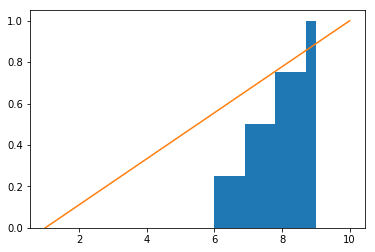

In [55]:
fig, ax = plt.subplots()
a = ax.hist(get_distribution([0, 10,10,10,10]), cumulative=True, density=True)
ax.plot((1,10), (0,1))

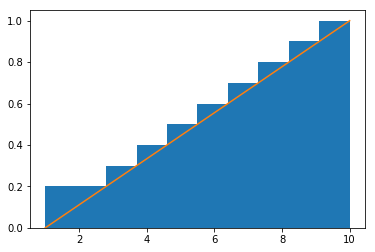

In [41]:
fig, ax = plt.subplots()
a = ax.hist([1,1,3,4,5,6,7,8,9,10], cumulative=True, density=True)
ax.plot((1,10), (0,1))

In [98]:
T('tt0317248')

0.3350418675826319

In [119]:
dfg = df_gini[df_gini.total>600]
dfg['gini2'] = dfg.tconst.apply(gini2)

/Users/leozeine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [120]:
dfg['T'] = dfg.tconst.apply(T)

/Users/leozeine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [124]:
dfg['index'] = dfg.tconst.apply(index2)

/Users/leozeine/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/leozeine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [229]:
dfg.sort_values(by='index', ascending=False)

,10,9,8,7,6,5,4,3,2,1,...,title,year,mean_,var_,kurt_,skew_,gini,T,gini2,index
tt0096194,74,16,28,17,34,43,52,58,81,320,...,Super Xuxa Contra o Baixo Astral,1988.0,3.471646,9.549334,2.695606,1.043070,0.461216,1.526117,0.461216,1.848479
tt5708172,59,14,29,57,98,150,134,118,95,427,...,Porta dos Fundos: Contrato Vitalício,2016.0,3.549534,6.853812,2.825660,0.824065,0.400812,1.344345,0.400812,1.116367
tt6791886,385,55,79,135,129,89,48,28,41,380,...,Como se Tornar o Pior Aluno da Escola,2017.0,5.755296,12.938659,1.474678,-0.179513,0.350127,1.222574,0.350127,0.836865
tt0100070,106,27,34,45,81,122,98,77,61,120,...,Lua de Cristal,1990.0,4.994812,8.461711,2.062163,0.337110,0.329989,1.137068,0.329989,0.806241
tt0765469,140,77,168,270,311,195,98,105,264,461,...,O Passado,0.0,4.721876,8.493734,1.764019,0.129846,0.350434,1.189905,0.350434,0.792776
tt5797820,165,36,63,103,89,56,20,17,29,211,...,Real: O Plano por Trás da História,2017.0,5.593156,11.681119,1.572116,-0.173493,0.344281,1.193348,0.344281,0.791494
tt0402505,113,60,87,129,91,48,24,42,71,115,...,Solo Dios Sabe,0.0,5.812821,9.398297,1.782249,-0.288983,0.299037,1.033394,0.299037,0.711447
tt1678040,77,37,65,91,138,155,98,62,51,82,...,Amor por Acaso,0.0,5.403037,6.520972,2.314721,0.041374,0.267805,0.919473,0.267805,0.704197
tt0171089,52,16,42,63,89,138,118,119,73,87,...,A Prisão,1980.0,4.676286,6.065849,2.564317,0.450498,0.295923,1.039950,0.295923,0.695857
tt8753660,151,39,55,121,128,107,67,39,46,185,...,Exterminadores do Além Contra a Loira do Banheiro,2018.0,5.450959,9.501326,1.827177,-0.060143,0.322133,1.083322,0.322133,0.691535


In [86]:
dfg.sort_values(by='gini2')

,10,9,8,7,6,5,4,3,2,1,...,tconst,title,year,mean_,var_,kurt_,skew_,gini,T,gini2
tt0317248,179804,215958,161600,61960,19164,8238,3935,2373,2177,9131,...,tt0317248,Cidade de Deus,2002.0,8.520788,2.432227,10.242092,-2.203306,0.088041,0.335042,0.088041
tt0271383,3501,2669,2234,876,268,136,53,44,35,145,...,tt0271383,O Auto da Compadecida,2000.0,8.621825,2.640941,9.786520,-2.191109,0.090479,0.338347,0.090479
tt1039960,540,856,1795,1087,292,82,27,22,29,41,...,tt1039960,Estômago,2007.0,7.861664,2.086082,7.983339,-1.469425,0.092610,0.385396,0.092610
tt2168180,259,323,685,497,148,41,16,4,2,15,...,tt2168180,Nise: O Coração da Loucura,2015.0,7.861307,1.980764,6.680099,-1.054268,0.093423,0.380340,0.093423
tt0333388,269,261,333,140,52,15,4,4,7,11,...,tt0333388,Edifício Master,2002.0,8.323905,2.427020,8.273856,-1.740108,0.094296,0.410039,0.094296
tt1789810,866,547,446,208,68,31,9,8,14,40,...,tt1789810,José e Pilar,0.0,8.626732,2.994779,9.355199,-2.206479,0.095388,0.355212,0.095388
tt0861739,18598,21122,31001,14702,4569,1666,683,390,267,1110,...,tt0861739,Tropa de Elite,2007.0,8.163918,2.397643,7.962195,-1.627339,0.096118,0.404492,0.096118
tt6293516,688,780,1091,619,194,70,23,10,14,42,...,tt6293516,Bingo: O Rei das Manhãs,2017.0,8.118663,2.460289,7.558576,-1.543158,0.098851,0.401015,0.098851
tt1555149,14722,17293,24120,12651,3952,1418,578,351,285,1036,...,tt1555149,Tropa de Elite 2: O Inimigo Agora é Outro,2010.0,8.116470,2.557555,7.785671,-1.643652,0.099767,0.409840,0.099767
tt0340468,1072,1407,2619,1572,542,179,67,52,38,83,...,tt0340468,Ônibus 174,2002.0,7.871708,2.454122,6.932087,-1.397491,0.101982,0.409165,0.101982


In [126]:
X = get_distribution(df_gini.loc['tt7825208']['10':'1'].values)
X_lorenz = X.cumsum() / X.sum()
X_lorenz = np.insert(X_lorenz, 0, 0)
X_lorenz[0], X_lorenz[-1]

(0.0, 1.0)

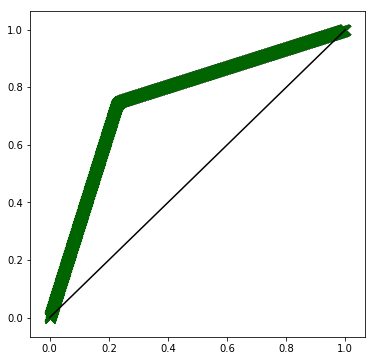

In [127]:
fig, ax = plt.subplots(figsize=[6,6])
## scatter plot of Lorenz curve
ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, 
           marker='x', color='darkgreen', s=100)
## line plot of equality
ax.plot([0,1], [0,1], color='k')


In [13]:
def index_final(tconst):
    gini = gini2(tconst)
    t = T(tconst)
    array = get_distribution(df_gini.loc[tconst]['10':'1'].values)
    return (t-gini)*(np.mean(array)/np.median(array))
    

In [205]:
df_gini['gini'] = df_gini.tconst.apply(gini2)

/Users/leozeine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [217]:
df_gini.sort_values(by='index_final', ascending=False)

,10,9,8,7,6,5,4,3,2,1,total,tconst,title,year,gini,T,index_final
tt7825208,9439,130,68,36,14,24,23,75,415,32059,42283,tt7825208,Marighella,2019.0,0.519111,2.907766,7.330755
tt2357958,400,36,64,45,25,11,15,16,42,2283,2937,tt2357958,Marighella,2012.0,0.506817,3.063421,6.816739
tt0496595,31,4,6,3,5,5,5,8,28,356,451,tt0496595,Xuxinha e Guto Contra os Monstros do Espaço,2005.0,0.445638,3.679638,6.640099
tt0286320,54,4,6,9,5,14,15,17,68,534,726,tt0286320,Xuxa Popstar,2000.0,0.454466,3.390386,6.340939
tt9214280,15,0,2,6,7,3,1,5,2,298,339,tt9214280,Eu Sou Mais Eu,2019.0,0.383169,4.038661,6.318933
tt2495980,81,7,16,16,23,40,29,43,45,2269,2569,tt2495980,É Fada!,2016.0,0.338294,4.331882,6.303621
tt0312043,51,2,3,6,4,15,9,18,13,336,457,tt0312043,Xuxa e os Duendes 2: No Caminho das Fadas,2002.0,0.490581,2.934949,6.124291
tt0285479,44,4,3,4,5,6,10,19,23,209,327,tt0285479,Cinderela Baiana,1998.0,0.500696,2.630065,6.121122
tt5431016,339,25,19,10,25,26,22,24,32,523,1045,tt5431016,Os Dez Mandamentos: O Filme,2016.0,0.460507,1.725108,5.886145
tt0294543,34,6,3,6,11,19,22,18,52,344,515,tt0294543,Xuxa e os Duendes,2001.0,0.461770,2.767455,5.421716


In [216]:
df_gini['index_final'] = df_gini.tconst.apply(index_final)

/Users/leozeine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [210]:
df_gini['T'] = df_gini.tconst.apply(T)

/Users/leozeine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [180]:
df_gini.sort_values(by='index_final', ascending=True)

,10,9,8,7,6,5,4,3,2,1,total,tconst,title,year,gini,T,index_final
tt0391726,29,2,4,4,7,13,12,15,30,191,307,tt0391726,Xuxa Abracadabra,2003.0,8.956686e+05,2.497889,-2.389415e+06
tt0285479,44,4,3,4,5,6,10,19,23,209,327,tt0285479,Cinderela Baiana,1998.0,7.326457e+05,2.630065,-2.106069e+06
tt9214280,15,0,2,6,7,3,1,5,2,298,339,tt9214280,Eu Sou Mais Eu,2019.0,1.133632e+06,4.038661,-1.959606e+06
tt0228778,26,9,3,8,6,22,31,29,49,264,447,tt0228778,Xuxa Requebra,1999.0,4.419338e+05,2.402025,-1.127073e+06
tt0496595,31,4,6,3,5,5,5,8,28,356,451,tt0496595,Xuxinha e Guto Contra os Monstros do Espaço,2005.0,5.392400e+05,3.679638,-1.107168e+06
tt0312043,51,2,3,6,4,15,9,18,13,336,457,tt0312043,Xuxa e os Duendes 2: No Caminho das Fadas,2002.0,4.303759e+05,2.934949,-1.078287e+06
tt0294543,34,6,3,6,11,19,22,18,52,344,515,tt0294543,Xuxa e os Duendes,2001.0,3.610923e+05,2.767455,-8.490863e+05
tt2109116,60,8,12,12,19,23,22,26,45,165,392,tt2109116,Desaparecidos,2011.0,3.824843e+05,1.679540,-7.327664e+05
tt2066141,10,1,8,15,30,37,41,45,52,165,404,tt2066141,Totalmente Inocentes,2012.0,4.603033e+05,1.498486,-6.898830e+05
tt0380165,54,22,21,9,20,20,34,34,32,121,367,tt0380165,Acquaria,2003.0,3.806611e+05,1.418325,-5.573328e+05


In [9]:
df.head()

,10,9,8,7,6,5,4,3,2,1,total
tt0022080,354,230,298,276,168,101,55,41,40,68,1631
tt0024049,39,30,50,78,54,20,15,6,2,3,297
tt0024743,2,0,1,1,1,2,0,0,0,0,7
tt0026063,1,1,1,1,1,0,0,0,1,0,6
tt0027278,3,1,2,5,11,2,2,0,0,0,26


In [10]:
#Democracia em vertigem
df.loc['tt6016744'].values

array([2565,  833, 1028,  610,  249,  131,   75,   73,  121, 1779, 7464])

## Curtose - Variância

In [484]:
df['kurt_inv'] = (df.kurt_)

In [609]:
#Fisher = False
def dist_max(title):
    return (math.sqrt((df[df.index==title]['kurt_'])**2+(df[df.index==title]['var_']-81/4)**2))

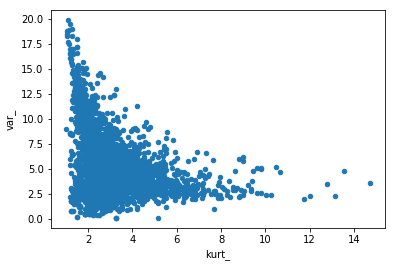

In [487]:
df.plot.scatter('kurt_', 'var_')

In [456]:
df['tconst'] = df.index

In [453]:
tconst = 'tt6791886'
df.loc[tconst].kurt_

1.4746781758988172

In [458]:
df.head()

,10,9,8,7,6,5,4,3,2,1,...,mean_,var_,kurt_,skew_,tconst,index,title,year,kurt_inv,index_pol
tt0022080,354,230,298,276,168,101,55,41,40,68,...,7.314531,5.771702,3.397639,-0.973236,tt0022080,-3.549549,Limite,1931.0,-0.397639,6.697499
tt0024049,39,30,50,78,54,20,15,6,2,3,...,7.121212,3.500459,3.383813,-0.481504,tt0024049,-2.848034,Ganga Bruta,1933.0,-0.383813,4.868614
tt0024743,2,0,1,1,1,2,0,0,0,0,...,7.285714,3.918367,1.545898,0.263867,tt0024743,-4.523727,A Voz do Carnaval,1933.0,1.454102,4.212292
tt0026063,1,1,1,1,1,0,0,0,1,0,...,7.000000,6.666667,2.715000,-0.871421,tt0026063,-4.044375,"Alô, Alô, Brasil",1935.0,0.285000,7.198310
tt0027278,3,1,2,5,11,2,2,0,0,0,...,6.692308,2.597633,2.948994,0.671554,tt0027278,-3.501991,Alô Alô Carnaval,1936.0,0.051006,3.929919


In [459]:
df['index_pol'] = df.tconst.apply(dist_cent)

In [610]:
df['index_pol2'] = df.tconst.apply(dist_max)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a24b450b8>,
      dtype=object)

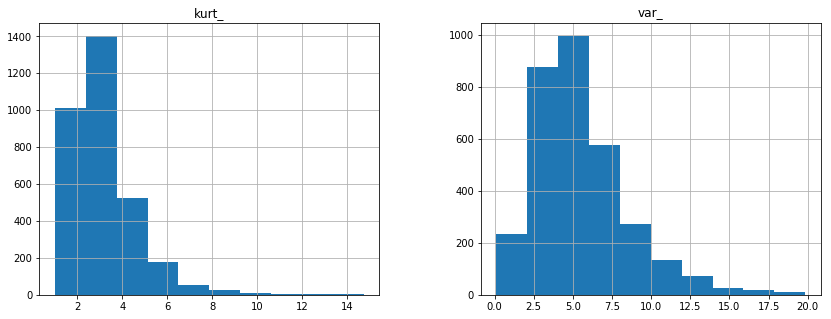

In [460]:
df.hist(['kurt_', 'var_'], figsize=(14,5))

In [142]:
a = np.arange(0, 14.5,1).astype(str)
a[0] = 'k_min'

In [143]:
a

array(['k_min', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0',
       '9.0', '10.0', '11.0', '12.0', '13.0', '14.0'], dtype='<U32')

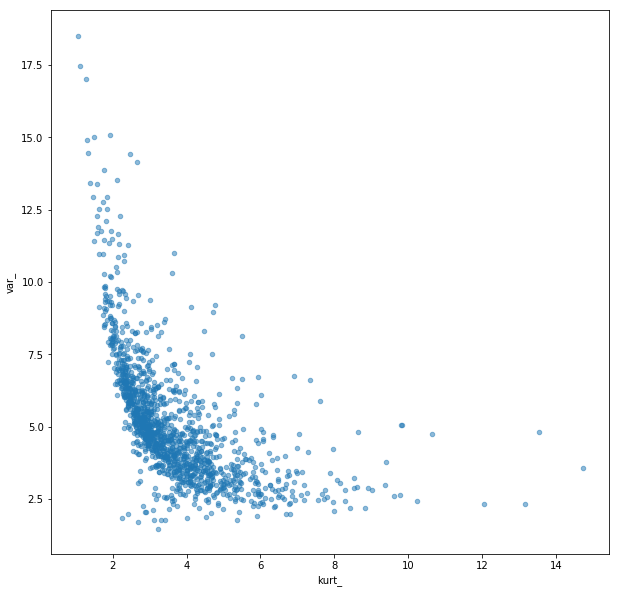

In [193]:
fig, ax = plt.subplots(figsize=(10,10))
df[(df.total>50) & (df.kurt_>3)].plot.scatter('kurt_', 'var_', figsize=(10,10), color='tab:blue', alpha=.5, ax=ax)
df[(df.total>50) & (df.kurt_<3)].plot.scatter('kurt_', 'var_', figsize=(10,10), color='tab:blue', alpha=.5, ax=ax)
plt.savefig('kurt_var.png', dpi=200)

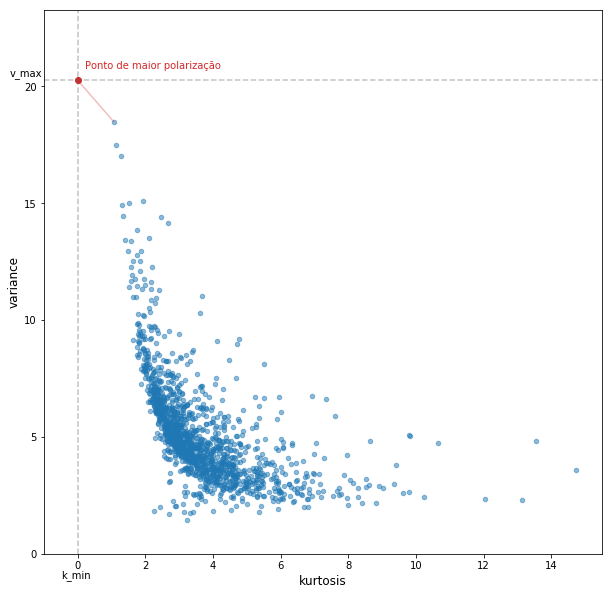

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
df[(df.total>50) & (df.kurt_>3)].plot.scatter('kurt_', 'var_', figsize=(10,10), color='tab:blue', alpha=.5, ax=ax)
df[(df.total>50) & (df.kurt_<3)].plot.scatter('kurt_', 'var_', figsize=(10,10), color='tab:blue', alpha=.5, ax=ax)
#plt.xlim(-15, 0)
plt.axvline(x=0, linestyle='--', color='dimgrey', alpha=.4)
plt.axhline(y=81/4, linestyle='--', color='dimgrey', alpha=.4)
plt.xlabel('kurtosis', fontsize=12)
plt.ylabel('variance', fontsize=12)
ax.text(-.5, -1, 'k_min')
ax.text(-2, 81/4+.2, 'v_max')
ax.text(0.2, 81/4+.5, 'Ponto de maior polarização', color='tab:red')
plt.plot((0,df[(df.total>50)].kurt_.min()), (81/4, df[df.kurt_==df[(df.total>50)].kurt_.min()].var_), color='tab:red', alpha=0.3, label='index_pol')
#plt.plot((0,df[(df.total>50)].kurt_.max()), (81/4, df[df.kurt_==df[(df.total>50)].kurt_.max()].var_), color='tab:red', alpha=0.3, label='index_pol')
plt.scatter(0, 81/4, color='tab:red')
#ax.text(4.5, 17.5, 'Distribuição normal\n(threshold)', horizontalalignment='center', fontsize=9, color='dimgrey')
plt.xlim(-1, 15.5)
#plt.axhline(y=81/8, linestyle='--', alpha=.3)
plt.ylim(0, 81/4+3)
plt.savefig('kurt_var_max.png', dpi=200, bbox_inches='tight')

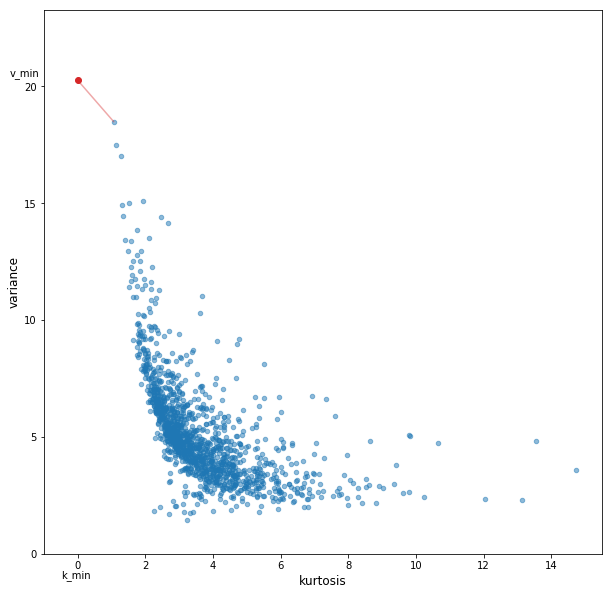

In [195]:
fig, ax = plt.subplots(figsize=(10,10))
df[(df.total>50) & (df.kurt_>3)].plot.scatter('kurt_', 'var_', figsize=(10,10), color='tab:blue', alpha=.5, ax=ax)
df[(df.total>50) & (df.kurt_<3)].plot.scatter('kurt_', 'var_', figsize=(10,10), color='tab:blue', alpha=.5, ax=ax)

plt.xlabel('kurtosis', fontsize=12)
plt.ylabel('variance', fontsize=12)
ax.text(-.5, -1, 'k_min')
ax.text(-2, 81/4+.2, 'v_min')
#ax.text(0.2, 81/4+.5, 'Ponto de maior polarização', color='tab:red')
plt.scatter(0, 81/4, color='tab:red')
plt.xlim(-1, 15.5)
plt.ylim(0, 81/4+3)

plt.plot((0,df[(df.total>50)].kurt_.min()), (81/4, df[df.kurt_==df[(df.total>50)].kurt_.min()].var_), color='tab:red', alpha=0.4, label='index_pol')
#plt.plot((0,1.319803), (81/4, 14.904321), color='tab:red', alpha=0.4, label='index_pol')
plt.savefig('kurt_var_index.png', dpi=200)

In [ ]:
df['meu']  

In [191]:
df_polarizado = df[(df.total>100)]
df_polarizado['index_meu'] = df_polarizado.tconst.apply(dist_cent)

/Users/leozeine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [238]:
df_polarizado['T'] = df_polarizado.tconst.apply(T)

/Users/leozeine/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/leozeine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [192]:
df_polarizado.sort_values(by='index_meu')

,10,9,8,7,6,5,4,3,2,1,total,tconst,title,year,mean_,var_,kurt_,skew_,index_meu
tt8528864,157,12,7,3,3,2,1,8,18,144,355,tt8528864,Bonifácio: O Fundador do Brasil,2018.0,5.608451,18.486126,1.060053,-0.043131,2.057903
tt10738914,210,2,2,6,11,12,10,22,30,177,482,tt10738914,Nada a Perder 2,2019.0,5.487552,17.469762,1.118929,0.051001,2.996953
tt5431016,339,25,19,10,25,26,22,24,32,523,1045,tt5431016,Os Dez Mandamentos: O Filme,2016.0,4.654545,16.995494,1.270600,0.389143,3.493742
tt6051554,398,58,59,60,27,22,11,11,18,259,923,tt6051554,The Garden of Afflictions,2017.0,6.541712,14.997989,1.510283,-0.541081,5.464849
tt6910020,16866,98,63,91,93,117,53,104,185,5092,22762,tt6910020,Nada a Perder,2018.0,7.811792,14.405049,2.463640,-1.194562,6.342947
tt0275425,49,2,8,4,4,6,15,7,22,97,214,tt0275425,Inspetor Faustão e o Mallandro: A Missão (Prim...,1991.0,4.093458,13.860424,1.759077,0.711614,6.627294
tt7825208,9439,130,68,36,14,24,23,75,415,32059,42283,tt7825208,Marighella,2019.0,3.068988,14.146625,2.668622,1.287380,6.661286
tt4930760,189,4,19,22,32,38,50,50,35,142,581,tt4930760,Diário de um Exorcista - Zero,2016.0,5.466437,13.408942,1.388222,0.110719,6.980489
tt10135068,171,32,43,14,16,12,10,18,34,77,427,tt10135068,1964: O Brasil Entre Armas e Livros,2019.0,6.639344,13.392176,1.571018,-0.539630,7.035471
tt9705194,29,4,1,1,0,1,4,11,23,59,133,tt9705194,Milagre,2019.0,3.759398,13.506021,2.105560,0.964391,7.065029


In [237]:
df_polarizado.sort_values(by='var_')

,10,9,8,7,6,5,4,3,2,1,total,tconst,title,year,mean_,var_,kurt_,skew_,index_meu
tt1319731,25,30,82,46,19,2,2,0,0,0,206,tt1319731,Pro Dia Nascer Feliz,2005.0,7.912621,1.458384,3.230422,-0.195999,19.067261
tt4611160,30,42,61,40,19,3,1,1,0,0,197,tt4611160,Últimas Conversas,2015.0,8.030457,1.755418,3.317423,-0.461833,18.789755
tt6788828,61,40,34,13,5,2,1,1,0,0,157,tt6788828,Martírio,2016.0,8.789809,1.771106,5.366850,-1.362506,19.242468
tt2139601,35,42,62,39,15,4,1,1,0,0,199,tt2139601,As Canções,2011.0,8.110553,1.786773,3.417842,-0.530617,18.776911
tt3096778,56,69,84,47,16,4,1,2,0,1,280,tt3096778,Cássia,2014.0,8.246429,1.921416,5.915636,-1.106174,19.259588
tt2168180,259,323,685,497,148,41,16,4,2,15,1990,tt2168180,Nise: O Coração da Loucura,2015.0,7.861307,1.980764,6.680099,-1.054268,19.452216
tt1754803,34,53,116,73,27,13,1,0,0,3,320,tt1754803,Uma Noite em 67,2010.0,7.781250,1.983398,6.805023,-1.105483,19.493001
tt8773976,13,9,24,33,14,9,0,0,0,0,102,tt8773976,Sepultura Endurance,2017.0,7.480392,1.994714,2.422925,0.196512,18.415375
tt6410688,22,24,43,9,11,2,0,2,0,0,113,tt6410688,Holocausto Brasileiro,2016.0,8.185841,2.027410,4.672582,-1.009954,18.812118
tt2091399,16,29,50,36,19,12,1,1,0,0,164,tt2091399,Rock Brasília: Era de Ouro,2011.0,7.646341,2.033462,2.899719,-0.384655,18.445883


In [532]:
df[(df.total>50) & (df.kurt_inv>-3) & (df.kurt_inv<-2.5) & (df.var_>12.5)]

,10,9,8,7,6,5,4,3,2,1,...,mean_,var_,kurt_,skew_,tconst,index,title,year,kurt_inv,index_pol
tt7825208,9439,130,68,36,14,24,23,75,415,32059,...,3.068988,14.146625,2.668622,1.28738,tt7825208,-4.988726,Marighella,2019.0,-2.668622,14.39613


'r = 11\nx1 = r*np.cos(theta)\nx2 = r*np.sin(theta)\nax.plot(x1, x2)'

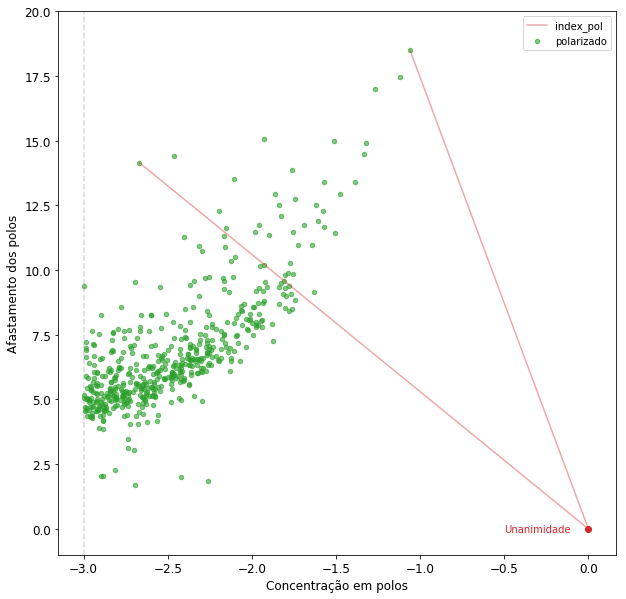

In [579]:
fig, ax = plt.subplots()
df[(df.total>50) & (df.kurt_inv>-3)].plot.scatter('kurt_inv', 'var_', figsize=(10,10), color='tab:green', alpha=.6, ax=ax, label='polarizado', fontsize=12)
plt.axvline(x=-3, linestyle='--', color='grey', alpha=.3)
plt.scatter([0],[0], color='tab:red')
plt.xlabel('Concentração em polos', fontsize=12)
plt.ylabel('Afastamento dos polos', fontsize=12)
ax.text(-.5, -.1, 'Unanimidade', color='tab:red', fontdict={'family':'Helvetica'})
plt.plot((0,df[(df.total>50)].kurt_.min()*-1), (0, df[df.kurt_==df[(df.total>50)].kurt_.min()].var_), color='tab:red', alpha=0.4, label='index_pol')
plt.plot((0,-2.668622), (0, 14.146625), color='tab:red', alpha=0.4)
plt.legend()
0.331378
#plt.xlim(-.2,2.7)
plt.ylim(-1,20)
theta = np.linspace(0, 2*np.pi, 100)


'''r = 11
x1 = r*np.cos(theta)
x2 = r*np.sin(theta)
ax.plot(x1, x2)'''


#plt.savefig('index_pol', dpi=200)


In [545]:
df_polarizado = df[(df.kurt_inv>-3)]
df_polarizado.shape

(1796, 21)

In [615]:
df_polarizado2 = df[(df.kurt_inv>-3)]

In [616]:
df_polarizado2.head()

,10,9,8,7,6,5,4,3,2,1,...,var_,kurt_,skew_,tconst,index,title,year,kurt_inv,index_pol,index_pol2
tt0024743,2,0,1,1,1,2,0,0,0,0,...,3.918367,1.545898,0.263867,tt0024743,-4.523727,A Voz do Carnaval,1933.0,-1.545898,4.212292,16.404634
tt0026063,1,1,1,1,1,0,0,0,1,0,...,6.666667,2.715000,-0.871421,tt0026063,-4.044375,"Alô, Alô, Brasil",1935.0,-2.715000,7.198310,13.852010
tt0027278,3,1,2,5,11,2,2,0,0,0,...,2.597633,2.948994,0.671554,tt0027278,-3.501991,Alô Alô Carnaval,1936.0,-2.948994,3.929919,17.897000
tt0033306,1,1,0,3,1,2,2,0,0,0,...,3.640000,2.174496,0.456177,tt0033306,-4.033601,24 Horas de Sonho,1941.0,-2.174496,4.240051,16.751732
tt0041219,1,1,0,0,4,1,0,0,0,0,...,2.979592,2.135391,0.887692,tt0041219,-4.652606,O Caçula do Barulho,1949.0,-2.135391,3.665769,17.401922


In [632]:
df_polarizado2[df_polarizado2.tconst=='tt6016744']

,10,9,8,7,6,5,4,3,2,1,...,kurt_,skew_,tconst,index,title,year,kurt_inv,index_pol,index_pol2,sum
tt6016744,2565,833,1028,610,249,131,75,73,121,1779,...,1.861599,-0.735682,tt6016744,-4.679629,The Edge of Democracy,2019.0,-1.861599,13.080248,7.53644,20.616689


In [546]:
df_polarizado.kurt_.min()

1.0

In [547]:
df[df.kurt_==df_polarizado.kurt_.min()]

,10,9,8,7,6,5,4,3,2,1,...,mean_,var_,kurt_,skew_,tconst,index,title,year,kurt_inv,index_pol
tt0140654,0,0,0,3,0,0,0,0,0,3,...,4.0,9.0,1.0,0.0,tt0140654,-5.0,Um Casal de 3,1984.0,-1.0,9.055385


In [548]:
df_polarizado['index_pol'] = df_polarizado.tconst.apply(dist_cent)

/Users/leozeine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [642]:
df_polarizado = df_polarizado.sort_values(by='index_pol', ascending=False)

In [643]:
df_polarizado2 = df_polarizado2.sort_values(by='index_pol2')

In [649]:
df_polarizado.tconst.values==df_polarizado2.tconst.values

array([ True,  True, False, ..., False, False, False])

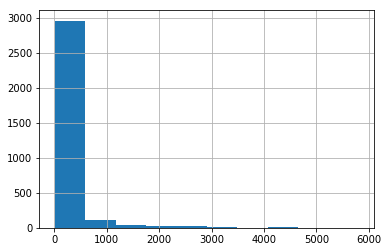

In [349]:
df[df.total<6000].total.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21680d68>]],
      dtype=object)

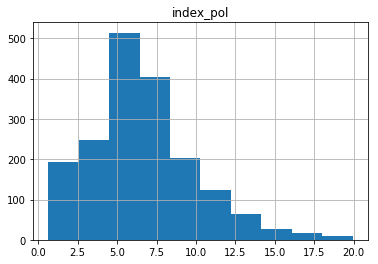

In [375]:
df[df.kurt_<0].hist('index_pol')

In [393]:
df[df.index_pol==df.index_pol.max()]

,10,9,8,7,6,5,4,3,2,1,...,mean_,var_,kurt_,skew_,tconst,index,title,year,kurt_inv,index_pol
tt0395134,4,0,0,0,0,0,0,0,0,3,...,6.142857,19.836735,-1.916667,-0.288675,tt0395134,-5.0,O Dono do Mar,2004.0,1.916667,19.929116


In [551]:
df_polarizado[(df_polarizado.total>100)]

,10,9,8,7,6,5,4,3,2,1,...,mean_,var_,kurt_,skew_,tconst,index,title,year,kurt_inv,index_pol
tt8528864,157,12,7,3,3,2,1,8,18,144,...,5.608451,18.486126,1.060053,-0.043131,tt8528864,-4.941808,Bonifácio: O Fundador do Brasil,2018.0,-1.060053,18.516494
tt10738914,210,2,2,6,11,12,10,22,30,177,...,5.487552,17.469762,1.118929,0.051001,tt10738914,-4.883672,Nada a Perder 2,2019.0,-1.118929,17.505559
tt5431016,339,25,19,10,25,26,22,24,32,523,...,4.654545,16.995494,1.270600,0.389143,tt5431016,-4.880832,Os Dez Mandamentos: O Filme,2016.0,-1.270600,17.042923
tt6051554,398,58,59,60,27,22,11,11,18,259,...,6.541712,14.997989,1.510283,-0.541081,tt6051554,-4.782485,The Garden of Afflictions,2017.0,-1.510283,15.073840
tt6910020,16866,98,63,91,93,117,53,104,185,5092,...,7.811792,14.405049,2.463640,-1.194562,tt6910020,-4.963340,Nada a Perder,2018.0,-2.463640,14.614204
tt7825208,9439,130,68,36,14,24,23,75,415,32059,...,3.068988,14.146625,2.668622,1.287380,tt7825208,-4.988726,Marighella,2019.0,-2.668622,14.396130
tt0275425,49,2,8,4,4,6,15,7,22,97,...,4.093458,13.860424,1.759077,0.711614,tt0275425,-4.747317,Inspetor Faustão e o Mallandro: A Missão (Prim...,1991.0,-1.759077,13.971604
tt9705194,29,4,1,1,0,1,4,11,23,59,...,3.759398,13.506021,2.105560,0.964391,tt9705194,-4.824490,Milagre,2019.0,-2.105560,13.669162
tt10135068,171,32,43,14,16,12,10,18,34,77,...,6.639344,13.392176,1.571018,-0.539630,tt10135068,-4.720183,1964: O Brasil Entre Armas e Livros,2019.0,-1.571018,13.484008
tt4930760,189,4,19,22,32,38,50,50,35,142,...,5.466437,13.408942,1.388222,0.110719,tt4930760,-4.624037,Diário de um Exorcista - Zero,2016.0,-1.388222,13.480612


In [552]:
df_try = df_polarizado[(df_polarizado.total>100)][['total', 'index_pol', 'title', 'year']].iloc[:30]
df_try

,total,index_pol,title,year
tt8528864,355,18.516494,Bonifácio: O Fundador do Brasil,2018.0
tt10738914,482,17.505559,Nada a Perder 2,2019.0
tt5431016,1045,17.042923,Os Dez Mandamentos: O Filme,2016.0
tt6051554,923,15.073840,The Garden of Afflictions,2017.0
tt6910020,22762,14.614204,Nada a Perder,2018.0
tt7825208,42283,14.396130,Marighella,2019.0
tt0275425,214,13.971604,Inspetor Faustão e o Mallandro: A Missão (Prim...,1991.0
tt9705194,133,13.669162,Milagre,2019.0
tt10135068,427,13.484008,1964: O Brasil Entre Armas e Livros,2019.0
tt4930760,581,13.480612,Diário de um Exorcista - Zero,2016.0


In [553]:
df_try['descrip'] = ['Direita - Olavo de Carvalho', 'Direita - Edir Macedo', 'Direita - Edir Macedo', 'Direita - Olavo de Carvalho', 'Direita - Edir Macedo', 'Esquerda','X','Direita - Olavo de Carvalho', \
                    'X', 'Direita - Olavo de Carvalho', 'Danilo Gentili (?)', 'Esquerda', 'Direita - Lava-Jato', 'youtuber (?)','Esquerda - doc Ditadura', 'Direita', 'Esquerda - Dilma','X', 'X', 'X', 'X','X','X','X','X - Duvivier', 'X', 'X', 'X', 'Esquerda - Impeachment', 'Esquerda'] 
                     
                     
                     

In [554]:
df_try.columns = ['total de reviews de usuarios', 'index_pol', 'title', 'year', 'descrip']

In [555]:
df_try[['title', 'year', 'descrip', 'total de reviews de usuarios', 'index_pol']].to_excel('df_try.xlsx', index=False)

In [556]:
df_try[['title', 'year', 'descrip', 'total de reviews de usuarios', 'index_pol']]

,title,year,descrip,total de reviews de usuarios,index_pol
tt8528864,Bonifácio: O Fundador do Brasil,2018.0,Direita - Olavo de Carvalho,355,18.516494
tt10738914,Nada a Perder 2,2019.0,Direita - Edir Macedo,482,17.505559
tt5431016,Os Dez Mandamentos: O Filme,2016.0,Direita - Edir Macedo,1045,17.042923
tt6051554,The Garden of Afflictions,2017.0,Direita - Olavo de Carvalho,923,15.073840
tt6910020,Nada a Perder,2018.0,Direita - Edir Macedo,22762,14.614204
tt7825208,Marighella,2019.0,Esquerda,42283,14.396130
tt0275425,Inspetor Faustão e o Mallandro: A Missão (Prim...,1991.0,X,214,13.971604
tt9705194,Milagre,2019.0,Direita - Olavo de Carvalho,133,13.669162
tt10135068,1964: O Brasil Entre Armas e Livros,2019.0,X,427,13.484008
tt4930760,Diário de um Exorcista - Zero,2016.0,Direita - Olavo de Carvalho,581,13.480612


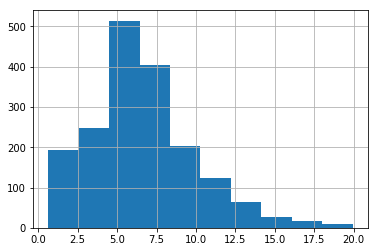

In [35]:
df_polarizado.index_pol.hist()

In [36]:
df_polarizado['title'] = [df_filmes[df_filmes.tconst==tconst].originalTitle.values[0] for tconst in df_polarizado.tconst]

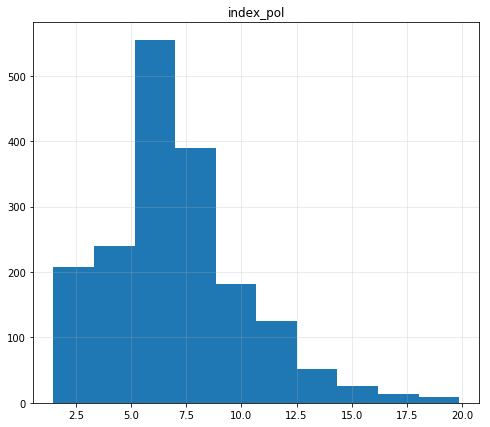

In [567]:
df_polarizado.hist('index_pol', figsize=(8,7))
plt.grid(True, alpha=.3)
plt.savefig('index_pol_hist.png', dpi=200)

In [37]:
df_polarizado['year'] = [df_filmes[df_filmes.tconst==tconst].year.values[0] for tconst in df_polarizado.tconst]

In [133]:
df_polarizado[df_polarizado.total>100].iloc[:20, :][['total', '']]

,10,9,8,7,6,5,4,3,2,1,...,mean_,var_,kurt_,skew_,tconst,index,index_pol,title,year,new_title
tt8528864,157,12,7,3,3,2,1,8,18,144,...,5.608451,18.486126,-1.939947,-0.043131,tt8528864,-4.941808,18.587637,Bonifácio: O Fundador do Brasil,2018.0,bonifacio o fundador do brasil
tt10738914,210,2,2,6,11,12,10,22,30,177,...,5.487552,17.469762,-1.881071,0.051001,tt10738914,-4.883672,17.570743,Nada a Perder 2,2019.0,nada a perder 2
tt5431016,339,25,19,10,25,26,22,24,32,523,...,4.654545,16.995494,-1.729400,0.389143,tt5431016,-4.880832,17.083256,Os Dez Mandamentos: O Filme,2016.0,os dez mandamentos o filme
tt6051554,398,58,59,60,27,22,11,11,18,259,...,6.541712,14.997989,-1.489717,-0.541081,tt6051554,-4.782485,15.071793,The Garden of Afflictions,2017.0,the garden of afflictions
tt6910020,16866,98,63,91,93,117,53,104,185,5092,...,7.811792,14.405049,-0.536360,-1.194562,tt6910020,-4.963340,14.415031,Nada a Perder,2018.0,nada a perder
tt7825208,9439,130,68,36,14,24,23,75,415,32059,...,3.068988,14.146625,-0.331378,1.287380,tt7825208,-4.988726,14.150506,Marighella,2019.0,marighella
tt0275425,49,2,8,4,4,6,15,7,22,97,...,4.093458,13.860424,-1.240923,0.711614,tt0275425,-4.747317,13.915863,Inspetor Faustão e o Mallandro: A Missão (Prim...,1991.0,inspetor faustao e o mallandro a missao (prime...
tt9705194,29,4,1,1,0,1,4,11,23,59,...,3.759398,13.506021,-0.894440,0.964391,tt9705194,-4.824490,13.535606,Milagre,2019.0,milagre
tt4930760,189,4,19,22,32,38,50,50,35,142,...,5.466437,13.408942,-1.611778,0.110719,tt4930760,-4.624037,13.505464,Diário de um Exorcista - Zero,2016.0,diario de um exorcista zero
tt10135068,171,32,43,14,16,12,10,18,34,77,...,6.639344,13.392176,-1.428982,-0.539630,tt10135068,-4.720183,13.468198,1964: O Brasil Entre Armas e Livros,2019.0,1964 o brasil entre armas e livros


In [129]:
df_polarizado.iloc[49:70, :][['total', 'index_pol', 'title', 'year']]

,total,index_pol,title,year
tt0443012,7,13.710283,O Gato de Botas Extraterrestre,1990.0
tt0382693,8,13.622846,Festive Land: Carnaval in Bahia,2001.0
tt3120274,13,13.571264,A Crime in Rio,2013.0
tt9705194,133,13.535606,Milagre,2019.0
tt4930760,581,13.505464,Diário de um Exorcista - Zero,2016.0
tt2553010,35,13.487329,Matadouro,2012.0
tt10135068,427,13.468198,1964: O Brasil Entre Armas e Livros,2019.0
tt0423926,13,13.403211,Calibre 12,1988.0
tt2569066,20,13.324766,2013 Menos 1,2012.0
tt1611807,20,13.320796,A Gruta - Filme Interativo,2008.0


In [120]:
df_polarizado = df_polarizado[df_polarizado.year>1980]

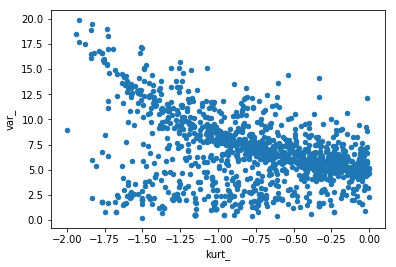

In [121]:
df_polarizado.plot.scatter('kurt_', 'var_')

In [87]:
def clean_name(name):
    return strip_accents(name.rstrip(string.punctuation).replace(',', '').replace('-', '').replace(':', '').lower())

In [93]:
import string
import unicodedata

def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

In [95]:
imdb_ancine.head()

,Ano de Lançamento,Certificado de Produto Brasileiro (CPB),Título,Direção,Gênero,Empresa Produtora Brasileira Majoritária,UF,Empresa Produtora Minoritária Brasileira,UF.1,Distribuidora,...,Art 1º,Art1 º A,Art. 3º,Art. 3º A,Conversão da dívida,Art. 39,Funcines,FSA,Outras Fontes (1),Valor Total Captado/ Contratados(R$)
0,1995,B0400064200000,A Causa Secreta,Sérgio Bianchi,Ficção,Agravo Produções Cinematográficas,SP,-,-,RioFilme,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
1,1995,B0500310700000,"Carlota Joaquina, Princesa do Brazil",Carla Camurati,Ficção,Copacabana Filmes e Produções,RJ,-,-,Elimar,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
2,1995,B0500264600000,Carmen Miranda - Bananas is my Business,Helena Solberg,Documentário,Radiante Filmes,RJ,-,-,RioFilme,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
4,1995,B0300012900000,Efeito Ilha,Luiz Alberto Pereira,Ficção,Lapfilme,SP,-,-,RioFilme,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
5,1995,B0500311400000,Louco por Cinema,André Luiz Oliveira,Ficção,Asacine Produções,DF,-,-,RioFilme,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0


In [103]:
df_polarizado['new_title'] = df_polarizado.title.apply(clean_name)

In [ ]:
imdb

In [105]:
imdb_ancine[imdb_ancine.new_title.isin(df_polarizado.new_title)].shape

(508, 27)

In [107]:
imdb_ancine[~imdb_ancine.new_title.isin(df_polarizado.new_title)]

,Ano de Lançamento,Certificado de Produto Brasileiro (CPB),Título,Direção,Gênero,Empresa Produtora Brasileira Majoritária,UF,Empresa Produtora Minoritária Brasileira,UF.1,Distribuidora,...,Art1 º A,Art. 3º,Art. 3º A,Conversão da dívida,Art. 39,Funcines,FSA,Outras Fontes (1),Valor Total Captado/ Contratados(R$),new_title
1,1995,B0500310700000,"Carlota Joaquina, Princesa do Brazil",Carla Camurati,Ficção,Copacabana Filmes e Produções,RJ,-,-,Elimar,...,0.00,0.00,0.0,0.0,0.00,0,0.00,0.0,0.00,carlota joaquina princesa do brazil
2,1995,B0500264600000,Carmen Miranda - Bananas is my Business,Helena Solberg,Documentário,Radiante Filmes,RJ,-,-,RioFilme,...,0.00,0.00,0.0,0.0,0.00,0,0.00,0.0,0.00,carmen miranda bananas is my business
4,1995,B0300012900000,Efeito Ilha,Luiz Alberto Pereira,Ficção,Lapfilme,SP,-,-,RioFilme,...,0.00,0.00,0.0,0.0,0.00,0,0.00,0.0,0.00,efeito ilha
6,1995,B0700675000000,Menino Maluquinho - O Filme,Helvécio Ratton,Ficção,Grupo Novo de Cinema e TV,RJ,-,-,S. Ribeiro/RioFilme,...,0.00,0.00,0.0,0.0,0.00,0,0.00,0.0,0.00,menino maluquinho o filme
7,1995,B1101392800000,O Mandarim,Julio Bressane,Ficção,Julio Bressane,RJ,-,-,RioFilme,...,0.00,0.00,0.0,0.0,0.00,0,0.00,0.0,0.00,o mandarim
8,1995,B0500309200000,O Quatrilho,Fábio Barreto,Ficção,Filmes do Equador,RJ,-,-,S. Ribeiro,...,0.00,0.00,0.0,0.0,0.00,0,0.00,0.0,1130552.00,o quatrilho
9,1995,B0500434300000,Perfume de Gardênia,Guilherme de Almeida Prado,Ficção,Star Filmes,SP,-,-,RioFilme,...,0.00,0.00,0.0,0.0,0.00,0,0.00,0.0,0.00,perfume de gardenia
10,1995,B0500277600000,Sábado,Ugo Giorgetti,Ficção,Iguana Filmes,SP,-,-,Mais Filmes,...,0.00,0.00,0.0,0.0,0.00,0,0.00,0.0,283000.00,sabado
12,1995,B0500310300000,Terra Estrangeira,Daniela Thomas/Walter Salles,Ficção,Videofilmes,RJ,-,-,RioFilme,...,0.00,0.00,0.0,0.0,0.00,0,0.00,0.0,180000.00,terra estrangeira
13,1995,B0400073200000,Yndio do Brasil,Sylvio Back,Documentário,Usina de Kyno,RJ,-,-,RioFilme,...,0.00,0.00,0.0,0.0,0.00,0,0.00,0.0,0.00,yndio do brasil


In [86]:
imdb_ancine.groupby('Ano de Lançamento').count()['Título']

1404

In [77]:
imdb_ancine[(imdb_ancine['Ano de Lançamento']>1995) & (imdb_ancine['Ano de Lançamento']<2017)].shape

(1249, 26)

In [66]:
imdb_ancine = fsa[~fsa['Certificado de Produto Brasileiro (CPB)'].isin(ancine_only['Certificado de Produto Brasileiro (CPB)'].values)]



In [71]:
imdb_ancine[imdb_ancine.Título.isin()]

(395, 20)

In [63]:
imdb_ancine.columns

Index(['Certificado de Produto Brasileiro (CPB)', 'Título', 'Direção',
       'Gênero', 'Empresa Produtora Brasileira Majoritária', 'UF',
       'Empresa Produtora Minoritária Brasileira', 'UF.1', 'Distribuidora',
       'Máximo de Salas', 'Renda (R$)', 'Público', 'Valor Total Aprovado(R$)',
       'Art.18', 'Art.25', 'Art 1º', 'Art1 º A', 'Art. 3º', 'Art. 3º A',
       'Conversão da dívida', 'Art. 39', 'Funcines', 'FSA',
       'Outras Fontes (1)', 'Valor Total Captado/ Contratados(R$)'],
      dtype='object')

In [117]:
df_polarizado[(df_polarizado.year>=1995) & (df_polarizado.year<=2017) & (df_polarizado.tconst.isin(pd.read_csv('IMDB_and_Ancine.csv')['tconst']))].shape
                                                                       
                                                                       
                                                                       

(586, 21)

In [118]:
df_polarizado[(df_polarizado.year>=1995) & (df_polarizado.year<=2017)].shape

(869, 21)

In [153]:
df

,10,9,8,7,6,5,4,3,2,1,total,mean_,var_,kurt_,skew_,tconst,index,title
tt0022080,354,230,298,276,168,101,55,41,40,68,1631,7.314531,5.771702,0.397639,-0.973236,tt0022080,-3.549549,Limite
tt0024049,39,30,50,78,54,20,15,6,2,3,297,7.121212,3.500459,0.383813,-0.481504,tt0024049,-2.848034,Ganga Bruta
tt0024743,2,0,1,1,1,2,0,0,0,0,7,7.285714,3.918367,-1.454102,0.263867,tt0024743,-4.523727,A Voz do Carnaval
tt0026063,1,1,1,1,1,0,0,0,1,0,6,7.000000,6.666667,-0.285000,-0.871421,tt0026063,-4.044375,"Alô, Alô, Brasil"
tt0027278,3,1,2,5,11,2,2,0,0,0,26,6.692308,2.597633,-0.051006,0.671554,tt0027278,-3.501991,Alô Alô Carnaval
tt0028780,6,3,13,31,23,12,3,1,1,0,93,6.698925,2.253440,0.755308,0.005808,tt0028780,-2.244726,O Descobrimento do Brasil
tt0032219,3,2,10,14,6,2,1,1,0,1,40,7.000000,3.000000,2.433333,-1.068098,tt0032219,-1.707500,Argila
tt0033306,1,1,0,3,1,2,2,0,0,0,10,6.400000,3.640000,-0.825504,0.456177,tt0033306,-4.033601,24 Horas de Sonho
tt0041219,1,1,0,0,4,1,0,0,0,0,7,6.857143,2.979592,-0.864609,0.887692,tt0041219,-4.652606,O Caçula do Barulho
tt0042018,1,1,3,3,1,3,3,0,1,1,17,5.882353,5.633218,-0.623852,-0.282338,tt0042018,-3.703567,Vendaval Maravilhoso


In [220]:
df_90 = df[(df.year>2000) & (df.total<12000)][['var_', 'kurt_', 'total', 'title', 'tconst']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1fad7080>]],
      dtype=object)

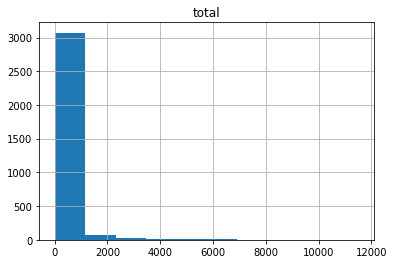

In [219]:
df[df.total<12000].hist('total')

In [221]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_90[['var_', 'kurt_', 'total']])
    Sum_of_squared_distances.append(km.inertia_)

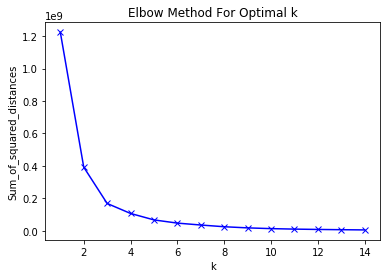

In [222]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [223]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df_90[['var_', 'kurt_']])

In [224]:
df_90['labels'] = kmeans.labels_

In [225]:
df_90.labels.value_counts()

1    820
3    561
2    208
0    151
Name: labels, dtype: int64

In [226]:
df_90[df_90.labels==1]

,var_,kurt_,total,title,tconst,labels
tt0171928,3.903853,0.749896,1016,O Xangô de Baker Street,tt0171928,1
tt0196811,5.189785,0.282271,2955,Olga,tt0196811,1
tt0243393,4.413223,-0.880045,11,Lua de Outubro,tt0243393,1
tt0262345,4.930612,0.558835,35,Condenado à Liberdade,tt0262345,1
tt0264446,4.850831,0.229662,369,Bufo & Spallanzani,tt0264446,1
tt0275915,3.663200,0.939161,1025,Amores Possíveis,tt0275915,1
tt0278396,3.596333,1.476571,151,Maldito - O Estranho Mundo de José Mojica Marins,tt0278396,1
tt0281708,1.290000,-0.753921,10,O Chamado de Deus,tt0281708,1
tt0284345,4.824262,0.522390,151,Netto Perde Sua Alma,tt0284345,1
tt0286560,4.373749,-0.310017,234,Copacabana,tt0286560,1


In [227]:
df_90[df_90.tconst=='tt6016744']

,var_,kurt_,total,title,tconst,labels
tt6016744,12.947098,-1.138401,7464,The Edge of Democracy,tt6016744,0


In [228]:
df_90[(df_90.labels==0) & (df_90.total>100)]

,var_,kurt_,total,title,tconst,labels
tt0380165,11.459124,-1.244006,367,Acquaria,tt0380165,0
tt10135068,13.392176,-1.428982,427,1964: O Brasil Entre Armas e Livros,tt10135068,0
tt10738914,17.469762,-1.881071,482,Nada a Perder 2,tt10738914,0
tt1116944,10.268300,-1.224933,196,"Maré, Nossa História de Amor",tt1116944,0
tt2109116,11.323693,-0.831623,392,Desaparecidos,tt2109116,0
tt2357958,11.013619,0.659447,2937,Marighella,tt2357958,0
tt4019666,10.209242,-1.071351,109,Desculpe o Transtorno,tt4019666,0
tt4930760,13.408942,-1.611778,581,Diário de um Exorcista - Zero,tt4930760,0
tt5231116,11.336588,-1.103688,109,A Capital dos Mortos 2: Mundo Morto,tt5231116,0
tt5431016,16.995494,-1.729400,1045,Os Dez Mandamentos: O Filme,tt5431016,0


In [685]:
!conda install -c conda-forge lmfit

Solving environment: - ^C
failed

CondaError: KeyboardInterrupt



In [686]:
import sys
!{sys.executable} -m pip install lmfit

     |████████████████████████████████| 266kB 1.6MB/s eta 0:00:01
     |████████████████████████████████| 61kB 3.1MB/s eta 0:00:011
     |████████████████████████████████| 235kB 1.3MB/s eta 0:00:01
  Created wheel for lmfit: filename=lmfit-1.0.0-cp36-none-any.whl size=87916 sha256=3c8b38cf3d61ffa9bb936d9382a79ab31b8df481fb13bb835126970f07e53b15
  Stored in directory: /Users/leozeine/Library/Caches/pip/wheels/1f/93/e9/8d3f759e466f5bbfed3ba1d7dc5b3d4389c469a1ec9a2acaee
  Created wheel for asteval: filename=asteval-0.9.18-cp36-none-any.whl size=17381 sha256=6af7f10e31b40b85d37c861ee9b61a9697d83847ed818fba54361925f6663e21
  Stored in directory: /Users/leozeine/Library/Caches/pip/wheels/1c/53/1b/28d929700c9633b1786a4982e6db564ec8326a8930234dcc19
  Created wheel for uncertainties: filename=uncertainties-3.1.2-cp36-none-any.whl size=96457 sha256=4904d4a4d5d82797ced409e558c46b51d0fbb49320cf2a96fb1e241d4a128f78
  Stored in directory: /Users/leozeine/Library/Caches/pip/wheels/d9/d3/0e/5b0b743a8a

[[Model]]
    (Model(jump) <function convolve at 0x1a276f6d08> Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 199
    # data points      = 322
    # variables        = 3
    chi-square         = 12044.8825
    reduced chi-square = 37.7582524
    Akaike info crit   = 1172.23364
    Bayesian info crit = 1183.55730
[[Variables]]
    mid:        5 (fixed)
    amplitude:  70.4389898 +/- 4.2882e+08 (608785240.68%) (init = 1)
    center:    -0.95664178 +/- 95824.7830 (10016788.43%) (init = 3.5)
    sigma:      0.03235512 +/- 11692.0752 (36136707.11%) (init = 1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, center) =  1.000
    C(center, sigma)     =  1.000
    C(amplitude, sigma)  =  1.000


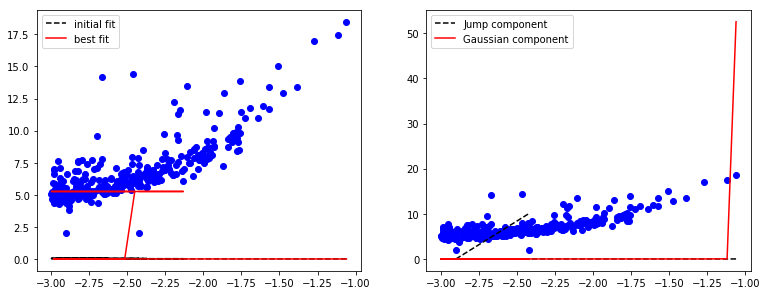

In [690]:
from lmfit import CompositeModel, Model
from lmfit import Model
from lmfit.lineshapes import gaussian, step

x = df_polarizado[df_polarizado.total>100].kurt_inv.values
y = df_polarizado[df_polarizado.total>100].var_.values

def jump(x, mid):
    """Heaviside step function."""
    o = np.zeros(x.size)
    imid = max(np.where(x <= mid)[0])
    o[imid:] = 1.0
    return o


def convolve(arr, kernel):
    """Simple convolution of two arrays."""
    npts = min(arr.size, kernel.size)
    pad = np.ones(npts)
    tmp = np.concatenate((pad*arr[0], arr, pad*arr[-1]))
    out = np.convolve(tmp, kernel, mode='valid')
    noff = int((len(out) - npts) / 2)
    return out[noff:noff+npts]


# create Composite Model using the custom convolution operator
mod = CompositeModel(Model(jump), Model(gaussian), convolve)
pars = mod.make_params(amplitude=1, center=3.5, sigma=1.5, mid=5.0)

# 'mid' and 'center' should be completely correlated, and 'mid' is
# used as an integer index, so a very poor fit variable:
pars['mid'].vary = False

# fit this model to data array y
result = mod.fit(y, params=pars, x=x)

print(result.fit_report())

# generate components
comps = result.eval_components(x=x)

# plot results
fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))

axes[0].plot(x, y, 'bo')
axes[0].plot(x, result.init_fit, 'k--', label='initial fit')
axes[0].plot(x, result.best_fit, 'r-', label='best fit')
axes[0].legend(loc='best')

axes[1].plot(x, y, 'bo')
axes[1].plot(x, 10*comps['jump'], 'k--', label='Jump component')
axes[1].plot(x, 10*comps['gaussian'], 'r-', label='Gaussian component')
axes[1].legend(loc='best')

plt.show()